In [63]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import spacy
#import community as community_louvain
from community import community_louvain

In [64]:
nlp = spacy.load("en_core_web_sm")

In [65]:
#load preprocessed data
preprocessed_data = pd.read_csv('Ukraine_before_conflict_preprocessed.csv')
preprocessed_data.head()

,article_title,author,published_time,article_text
0,Ukrainian president expects no conflict with R...,By Xinhua,"Published: Feb 23, 2022 09:34 AM",Ukraine President Volodymyr Zelensky attends a...
1,British PM announces sanctions against Russia ...,By Xinhua,"Published: Feb 23, 2022 09:37 AM",UK Prime Minister Boris Johnson Photo: VCG UK ...
2,NATO chief urges Russia to choose diplomacy in...,By Xinhua,"Published: Feb 23, 2022 09:41 AM",NATO Secretary General Jens Stoltenberg speaks...
3,"EU agrees Russia sanctions package, warns of f...",By Xinhua,"Published: Feb 23, 2022 09:42 AM",EU Commission President Ursula von der Leyen m...
4,Russia's upper house approves use of military ...,By Xinhua,"Published: Feb 23, 2022 09:48 AM",Russia President Vladimir Putin signs document...


In [66]:
entities = [
    "Russia", "Moscow", "China", "Beijing", "Ukraine",
    "Kiev", "US", "France", "West", "Joe Biden",
    "Xi Jinping", "Vladimir Putin", "Wang Yi", "Antony Blinken", "Volodymyr Zelensky",
    "Donald Trump", "Emmanuel Macron", "EU",
    "NATO", "UN"
] #"EU Commission", "EU Council", "Covid-19"

# Relationship with co-occurence based in same sentence

In [67]:
#initialize graph
G = nx.Graph()

#add nodes for each entity
for entity in entities:
    G.add_node(entity)

In [68]:
co_occurrence = defaultdict(int)

In [69]:
#iterate through the articles and process with SpaCy to get sentences
for article in preprocessed_data['article_text']:
    doc = nlp(article)
    sentences = [sent.text for sent in doc.sents]
    #print(sentences)

    #iterate through each sentence in the article
    for sentence in sentences:
        present_entities = [entity for entity in entities if entity in sentence]
        #print(present_entities)
        for i in range(len(present_entities)):
            for j in range(i + 1, len(present_entities)):
                co_occurrence[(present_entities[i], present_entities[j])] += 1
                #print(co_occurrence)

In [70]:
co_occurrence

defaultdict(int,
            {('Ukraine', 'Kiev'): 34,
             ('Ukraine', 'Volodymyr Zelensky'): 21,
             ('Kiev', 'Volodymyr Zelensky'): 7,
             ('Russia', 'Ukraine'): 359,
             ('Russia', 'Vladimir Putin'): 118,
             ('Russia', 'Volodymyr Zelensky'): 6,
             ('Ukraine', 'Vladimir Putin'): 38,
             ('Vladimir Putin', 'Volodymyr Zelensky'): 1,
             ('Russia', 'Kiev'): 11,
             ('US', 'EU'): 177,
             ('Russia', 'West'): 181,
             ('Ukraine', 'West'): 82,
             ('West', 'Vladimir Putin'): 22,
             ('Ukraine', 'NATO'): 103,
             ('Russia', 'NATO'): 164,
             ('Ukraine', 'EU'): 92,
             ('EU', 'NATO'): 59,
             ('US', 'NATO'): 120,
             ('Russia', 'Moscow'): 84,
             ('Moscow', 'Ukraine'): 44,
             ('Vladimir Putin', 'EU'): 9,
             ('Vladimir Putin', 'NATO'): 21,
             ('Russia', 'EU'): 164,
             ('Russia', 'Joe

In [71]:
#define a threshold for edge weights for visualization purposes
weight_threshold = 10

In [72]:
#add edges with weights to the graph, filtering by the threshold
selected_edges = []
for (entity1, entity2), weight in co_occurrence.items():
    if weight >= weight_threshold:
        G.add_edge(entity1, entity2, weight=weight)
        selected_edges.append((entity1, entity2, weight))

In [73]:
selected_edges

[('Ukraine', 'Kiev', 34),
 ('Ukraine', 'Volodymyr Zelensky', 21),
 ('Russia', 'Ukraine', 359),
 ('Russia', 'Vladimir Putin', 118),
 ('Ukraine', 'Vladimir Putin', 38),
 ('Russia', 'Kiev', 11),
 ('US', 'EU', 177),
 ('Russia', 'West', 181),
 ('Ukraine', 'West', 82),
 ('West', 'Vladimir Putin', 22),
 ('Ukraine', 'NATO', 103),
 ('Russia', 'NATO', 164),
 ('Ukraine', 'EU', 92),
 ('EU', 'NATO', 59),
 ('US', 'NATO', 120),
 ('Russia', 'Moscow', 84),
 ('Moscow', 'Ukraine', 44),
 ('Vladimir Putin', 'NATO', 21),
 ('Russia', 'EU', 164),
 ('Russia', 'Joe Biden', 55),
 ('Ukraine', 'Joe Biden', 38),
 ('Moscow', 'Vladimir Putin', 21),
 ('US', 'Joe Biden', 119),
 ('West', 'EU', 39),
 ('Russia', 'US', 468),
 ('Moscow', 'US', 63),
 ('Moscow', 'NATO', 27),
 ('Joe Biden', 'NATO', 10),
 ('Russia', 'Antony Blinken', 16),
 ('Ukraine', 'Antony Blinken', 31),
 ('China', 'Ukraine', 160),
 ('China', 'US', 566),
 ('China', 'West', 125),
 ('Ukraine', 'US', 285),
 ('US', 'West', 112),
 ('China', 'Beijing', 80),
 ('Kie

In [74]:
#calculate node strength -- the sum of the weights of edges connected to them
node_strength = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes}
max_strength = max(node_strength.values())

In [75]:
#normalize node sizes based on their strength
node_sizes = [node_strength[node] / max_strength * 1000 for node in G.nodes]

In [76]:
#apply the Louvain method for community detection
partition = community_louvain.best_partition(G, weight='weight')

In [77]:
partition

{'Russia': 0,
 'Moscow': 0,
 'China': 2,
 'Beijing': 2,
 'Ukraine': 0,
 'Kiev': 0,
 'US': 2,
 'France': 1,
 'West': 0,
 'Joe Biden': 2,
 'Xi Jinping': 0,
 'Vladimir Putin': 0,
 'Wang Yi': 2,
 'Antony Blinken': 2,
 'Volodymyr Zelensky': 0,
 'Donald Trump': 2,
 'Emmanuel Macron': 1,
 'EU': 0,
 'NATO': 0,
 'UN': 2}

In [78]:
#add the community information to the graph
for node, community in partition.items():
    G.nodes[node]['community'] = community

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


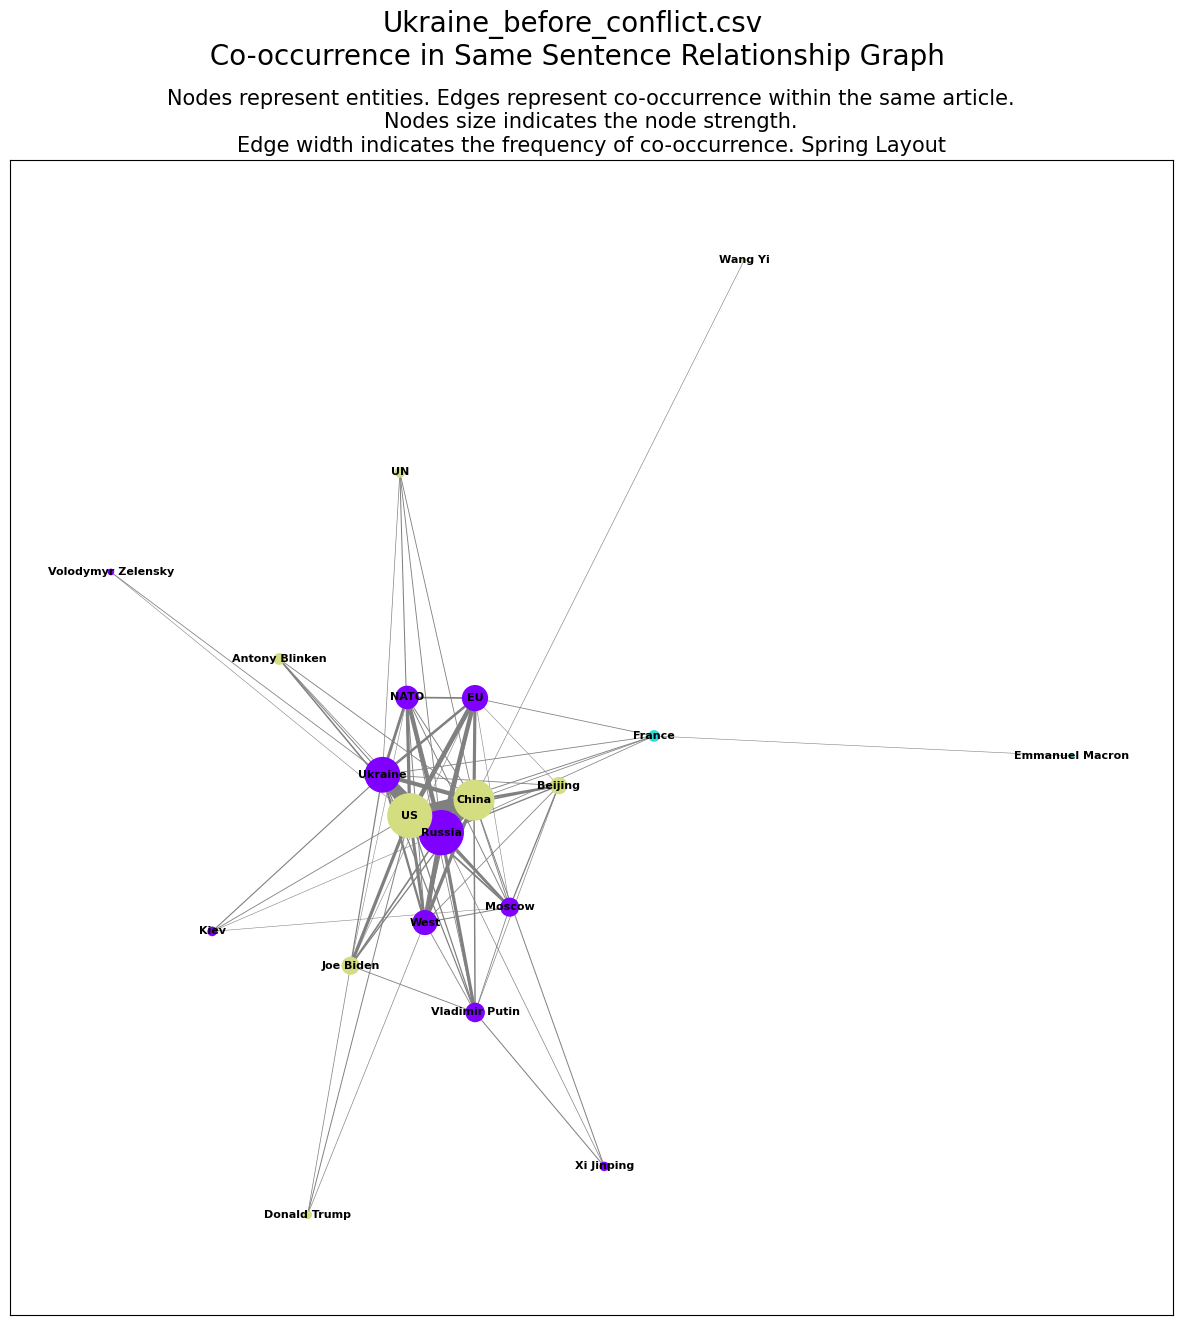

In [79]:
#draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)

#get the community color map
communities = set(partition.values())
colors = [plt.cm.rainbow(i / len(communities)) for i in range(len(communities))]
node_colors = [colors[partition[node]] for node in G.nodes]

#draw nodes with community colors
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.rainbow, node_color=node_colors)

#draw edges with normalized weights
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
max_weight = max(weights)
min_width = 0.2
normalized_weights = [(weight / max_weight * 10) + min_width for weight in weights]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=normalized_weights, edge_color='gray')

#draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

#labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

#title
plt.suptitle("Ukraine_before_conflict.csv\n Co-occurrence in Same Sentence Relationship Graph", fontsize=20)
plt.title("Nodes represent entities. Edges represent co-occurrence within the same article.\nNodes size indicates the node strength.\nEdge width indicates the frequency of co-occurrence. Spring Layout", fontsize=15)
plt.show()

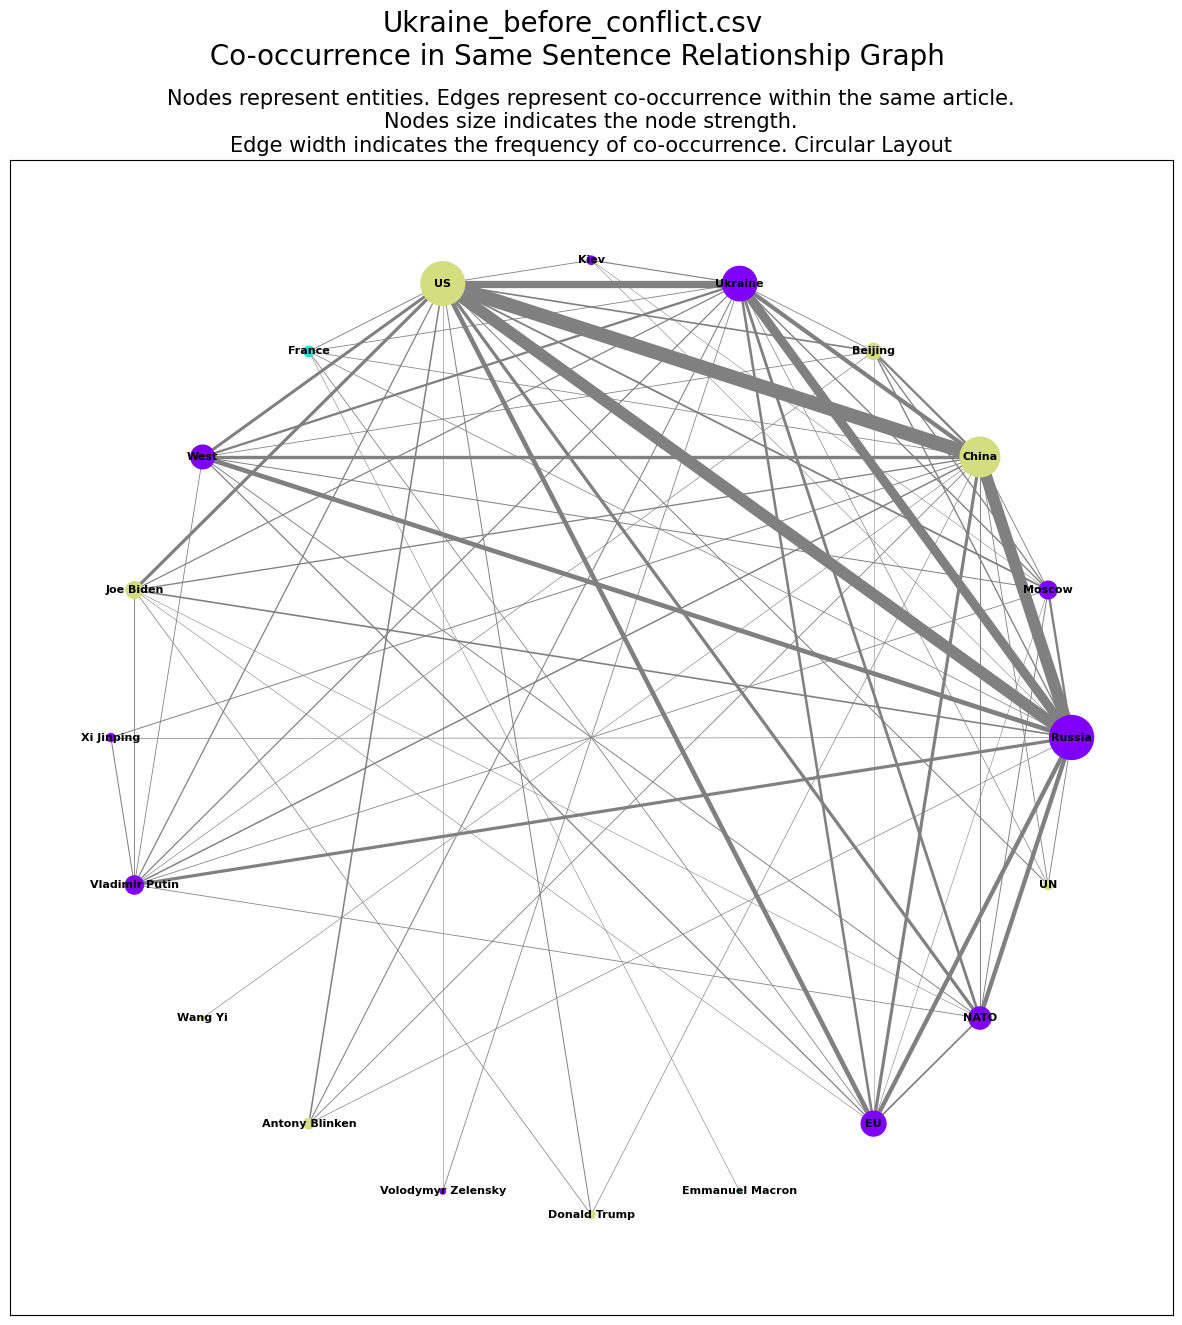

In [80]:
#draw the graph
plt.figure(figsize=(15, 15))
pos = nx.circular_layout(G)

#get the community color map
communities = set(partition.values())
colors = [plt.cm.rainbow(i / len(communities)) for i in range(len(communities))]
node_colors = [colors[partition[node]] for node in G.nodes]

#draw nodes with community colors
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.rainbow, node_color=node_colors)

#draw edges with normalized weights
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
max_weight = max(weights)
min_width = 0.2
normalized_weights = [(weight / max_weight * 10) + min_width for weight in weights]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=normalized_weights, edge_color='gray')

#draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

#labels = nx.get_edge_attributes(G, 'weight')
#x.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

#add title and show plot
plt.suptitle("Ukraine_before_conflict.csv\n Co-occurrence in Same Sentence Relationship Graph", fontsize=20)
plt.title("Nodes represent entities. Edges represent co-occurrence within the same article.\nNodes size indicates the node strength.\nEdge width indicates the frequency of co-occurrence. Circular Layout", fontsize=15)
plt.show()

# Relationship with co-occurence based in same article

In [81]:
#initialize graph
G = nx.Graph()

#add nodes for each entity
for entity in entities:
    G.add_node(entity)

In [82]:
co_occurrence = defaultdict(int)

#iterate through each article in the preprocessed dataset
for article in preprocessed_data['article_text']:
    #find all entities present in the article
    present_entities = [entity for entity in entities if entity in article]
    #print(present_entities)

    #track co-occurrences within the article
    for i in range(len(present_entities)):
        for j in range(i + 1, len(present_entities)):
            co_occurrence[(present_entities[i], present_entities[j])] += 1
            #print(co_occurrence)

In [83]:
co_occurrence

defaultdict(int,
            {('Russia', 'Ukraine'): 145,
             ('Russia', 'Kiev'): 26,
             ('Russia', 'Vladimir Putin'): 50,
             ('Russia', 'Volodymyr Zelensky'): 9,
             ('Ukraine', 'Kiev'): 35,
             ('Ukraine', 'Vladimir Putin'): 51,
             ('Ukraine', 'Volodymyr Zelensky'): 11,
             ('Kiev', 'Vladimir Putin'): 9,
             ('Kiev', 'Volodymyr Zelensky'): 9,
             ('Vladimir Putin', 'Volodymyr Zelensky'): 2,
             ('Russia', 'US'): 123,
             ('Russia', 'West'): 84,
             ('Russia', 'EU'): 95,
             ('Ukraine', 'US'): 149,
             ('Ukraine', 'West'): 93,
             ('Ukraine', 'EU'): 111,
             ('US', 'West'): 86,
             ('US', 'Vladimir Putin'): 44,
             ('US', 'EU'): 97,
             ('West', 'Vladimir Putin'): 35,
             ('West', 'EU'): 67,
             ('Vladimir Putin', 'EU'): 35,
             ('Russia', 'Moscow'): 63,
             ('Russia', 'NATO'): 

In [84]:
#define a threshold for edge weights for visualization purposes
weight_threshold = 10

In [85]:
#add edges with weights to the graph, filtering by the threshold
selected_edges = []
for (entity1, entity2), weight in co_occurrence.items():
    if weight >= weight_threshold:
        G.add_edge(entity1, entity2, weight=weight)
        selected_edges.append((entity1, entity2, weight))

In [86]:
selected_edges

[('Russia', 'Ukraine', 145),
 ('Russia', 'Kiev', 26),
 ('Russia', 'Vladimir Putin', 50),
 ('Ukraine', 'Kiev', 35),
 ('Ukraine', 'Vladimir Putin', 51),
 ('Ukraine', 'Volodymyr Zelensky', 11),
 ('Russia', 'US', 123),
 ('Russia', 'West', 84),
 ('Russia', 'EU', 95),
 ('Ukraine', 'US', 149),
 ('Ukraine', 'West', 93),
 ('Ukraine', 'EU', 111),
 ('US', 'West', 86),
 ('US', 'Vladimir Putin', 44),
 ('US', 'EU', 97),
 ('West', 'Vladimir Putin', 35),
 ('West', 'EU', 67),
 ('Vladimir Putin', 'EU', 35),
 ('Russia', 'Moscow', 63),
 ('Russia', 'NATO', 64),
 ('Moscow', 'Ukraine', 64),
 ('Moscow', 'US', 59),
 ('Moscow', 'Vladimir Putin', 34),
 ('Moscow', 'EU', 45),
 ('Moscow', 'NATO', 42),
 ('Ukraine', 'NATO', 66),
 ('US', 'NATO', 62),
 ('Vladimir Putin', 'NATO', 28),
 ('EU', 'NATO', 55),
 ('Russia', 'Joe Biden', 52),
 ('Ukraine', 'Joe Biden', 54),
 ('Joe Biden', 'Vladimir Putin', 21),
 ('Joe Biden', 'EU', 36),
 ('Joe Biden', 'NATO', 29),
 ('Moscow', 'Kiev', 15),
 ('Russia', 'Antony Blinken', 22),
 ('Mo

In [87]:
#calculate node strength -- the sum of the weights of edges connected to them
node_strength = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes}
max_strength = max(node_strength.values())

In [88]:
#normalize node sizes based on their strength
node_sizes = [node_strength[node] / max_strength * 1000 for node in G.nodes]

In [89]:
#apply the Louvain method for community detection
partition = community_louvain.best_partition(G, weight='weight')

In [90]:
partition

{'Russia': 0,
 'Moscow': 0,
 'China': 0,
 'Beijing': 0,
 'Ukraine': 0,
 'Kiev': 0,
 'US': 0,
 'France': 0,
 'West': 0,
 'Joe Biden': 0,
 'Xi Jinping': 0,
 'Vladimir Putin': 0,
 'Wang Yi': 0,
 'Antony Blinken': 0,
 'Volodymyr Zelensky': 0,
 'Donald Trump': 0,
 'Emmanuel Macron': 0,
 'EU': 0,
 'NATO': 0,
 'UN': 0}

In [91]:
#add the community information to the graph
for node, community in partition.items():
    G.nodes[node]['community'] = community

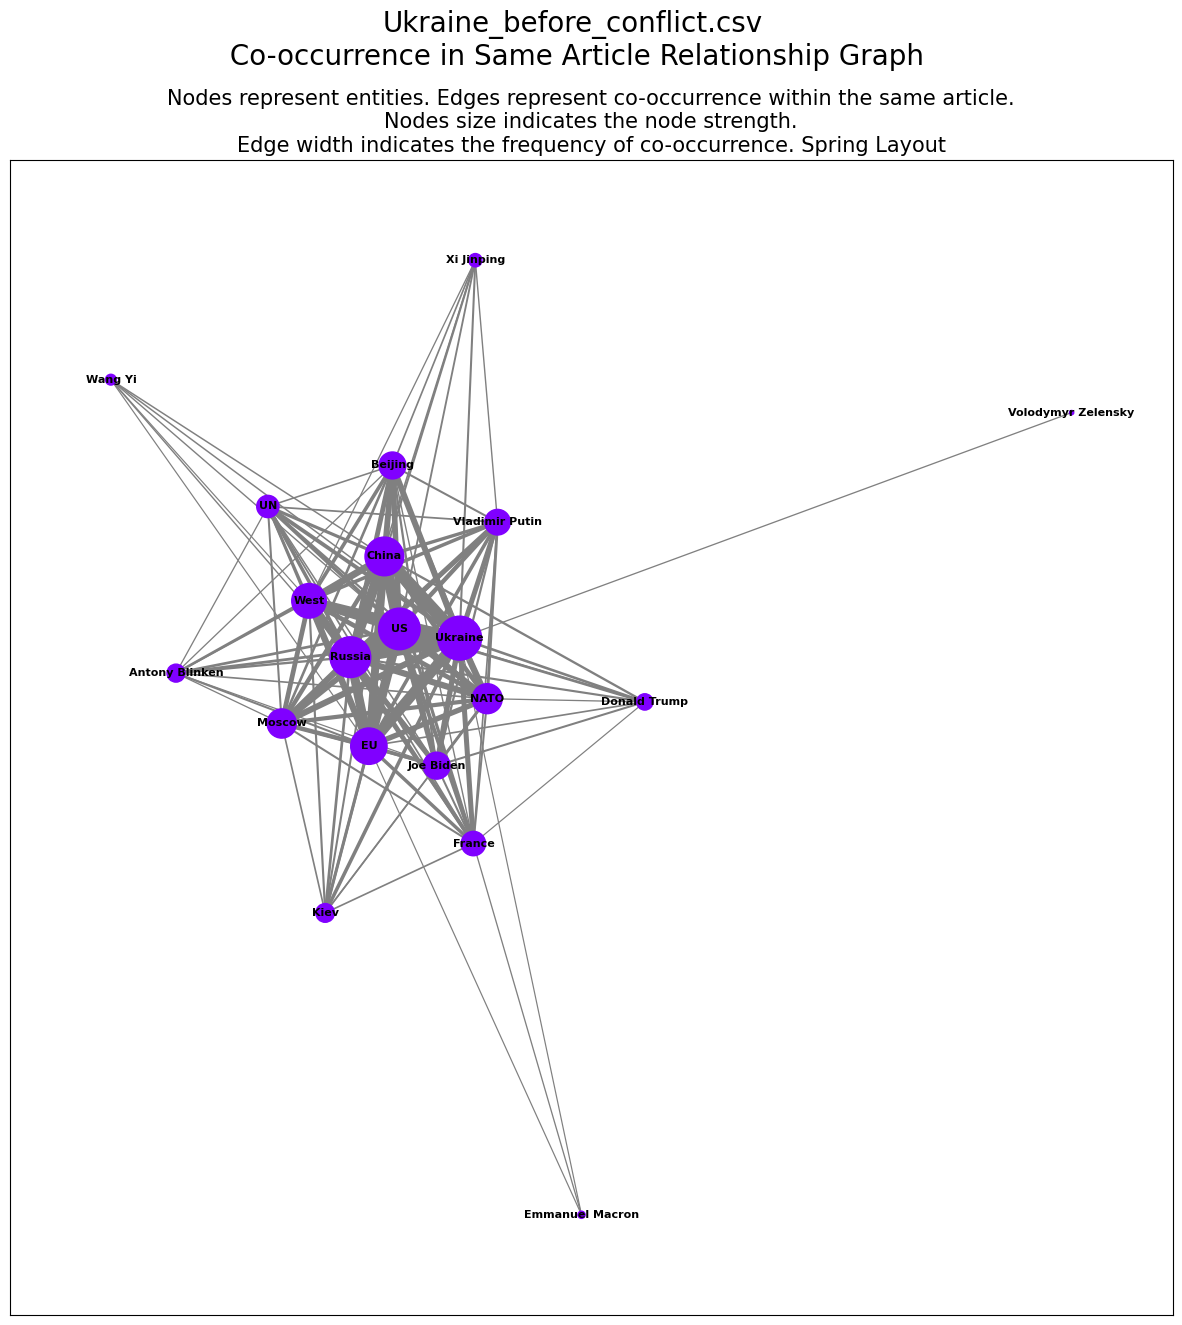

In [92]:
#draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)

#get the community color map
communities = set(partition.values())
colors = [plt.cm.rainbow(i / len(communities)) for i in range(len(communities))]
node_colors = [colors[partition[node]] for node in G.nodes]

#draw nodes with community colors
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.rainbow, node_color=node_colors)

#draw edges with normalized weights
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
max_weight = max(weights)
min_width = 0.2
normalized_weights = [(weight / max_weight * 10) + min_width for weight in weights]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=normalized_weights, edge_color='gray')

#draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

#labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

#add title and show plot
plt.suptitle("Ukraine_before_conflict.csv\n Co-occurrence in Same Article Relationship Graph", fontsize=20)
plt.title("Nodes represent entities. Edges represent co-occurrence within the same article.\nNodes size indicates the node strength.\nEdge width indicates the frequency of co-occurrence. Spring Layout", fontsize=15)
plt.show()

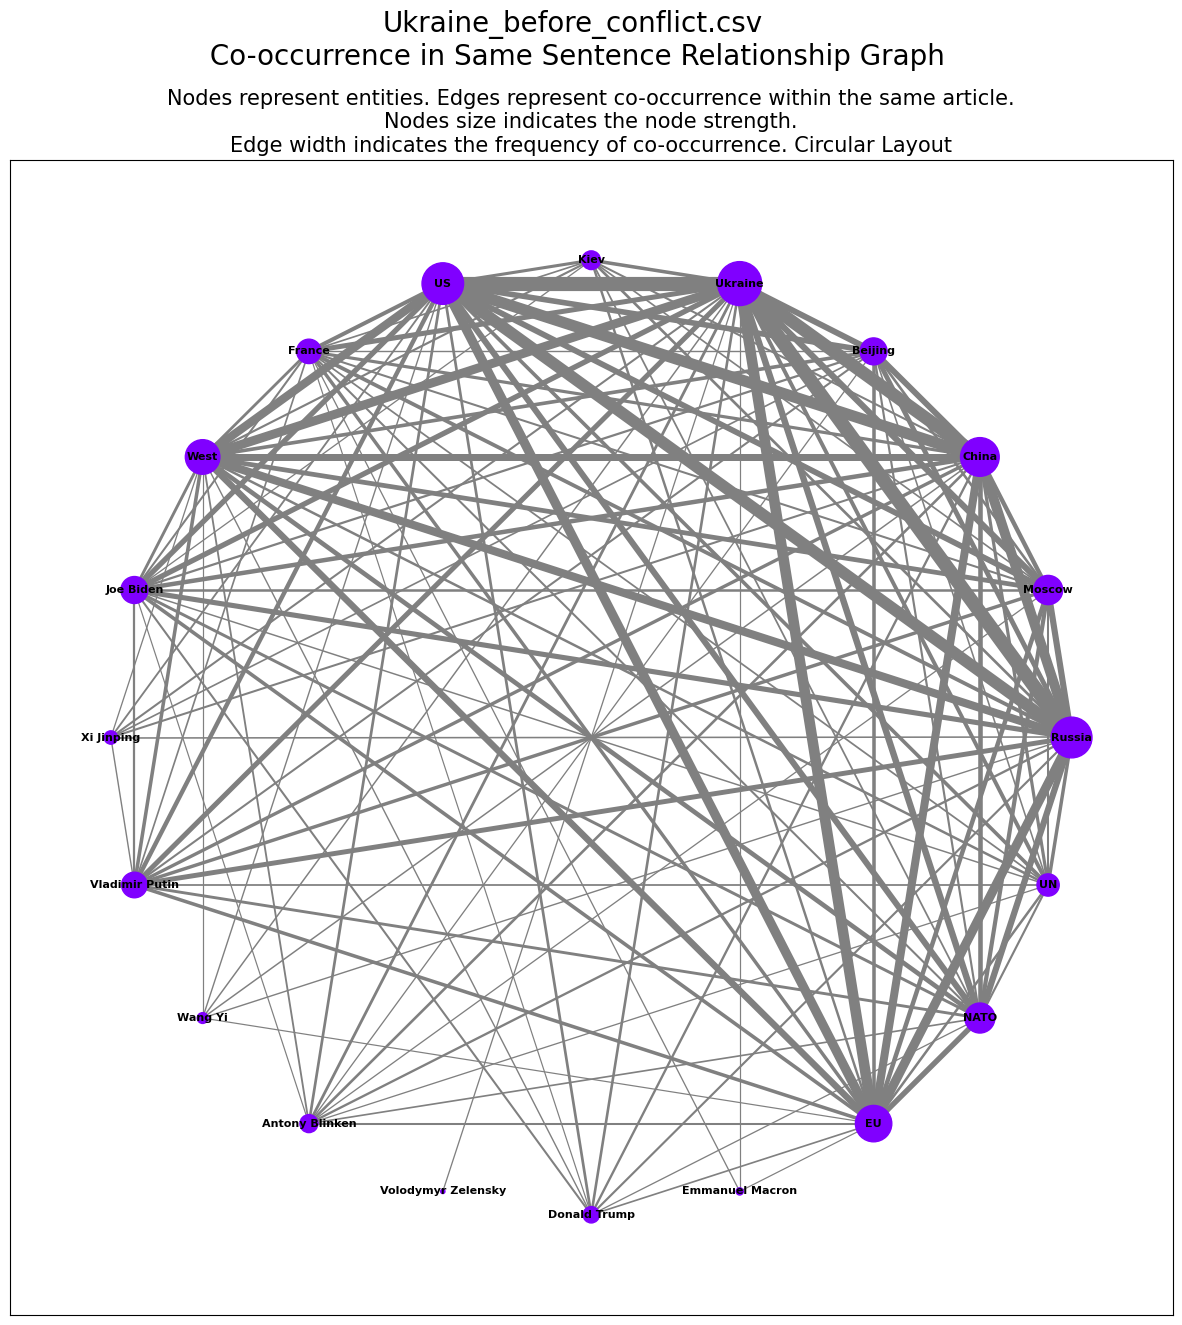

In [93]:
#draw the graph
plt.figure(figsize=(15, 15))
pos = nx.circular_layout(G)

#get the community color map
communities = set(partition.values())
colors = [plt.cm.rainbow(i / len(communities)) for i in range(len(communities))]
node_colors = [colors[partition[node]] for node in G.nodes]

#draw nodes with community colors
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.rainbow, node_color=node_colors)

#draw edges with normalized weights
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
max_weight = max(weights)
min_width = 0.2
normalized_weights = [(weight / max_weight * 10) + min_width for weight in weights]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=normalized_weights, edge_color='gray')

#draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

#labels = nx.get_edge_attributes(G, 'weight')
#x.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

#add title and show plot
plt.suptitle("Ukraine_before_conflict.csv\n Co-occurrence in Same Sentence Relationship Graph", fontsize=20)
plt.title("Nodes represent entities. Edges represent co-occurrence within the same article.\nNodes size indicates the node strength.\nEdge width indicates the frequency of co-occurrence. Circular Layout", fontsize=15)
plt.show()